# Create Hexagons

#### !!! As this notebook uses h3 package it will NOT WORK ON WINDOWS !!!

This notebook creates hexagons lying above the bounding boxes of the city Dresden. For spatial analysis these hexagons are very helpful.

### What is done?
1. Load GeoJSON of Dresdens bounding box
2. Polyfill region of Dresden with Hexagons by given resolution
3. Plot and save the hexagons in a dataframe and csv
4. Match corresponding hexagons to start and endpoints of trips
5. Save them into csv file chunks
    - This has to be done because the file is too big to be uplaoded to Github
    - But as h3 package is not working on Windows, we have to upload these files so everyone has these information
    - The next notebook (03_MergeHexagonChunks) can then be run on Windows
    - It loads the chunks and merges them again, creating a Trips_Hexagons.csv (which is on gitignore)

### Input

- data/output/Trips.csv
- data/input/dresden_bounding_box.geojson

### Output
- data/output/hexagons-dresden.csv
- data/output/trips-hexagons/trips-hexagons-{id}.csv
    - (Multiple chunkfiles, each with antoher number as id)
    
---------------------------------------------------------

## 0. Pre-Installations of packages
Copy one of these lines into the next cell. Beware: pip does not like comments so paste it, run the cell and delete it again!
- pip install geopandas
- pip install h3
- pip install matplotlib
- pip install descartes

In [1]:
import pandas as pd
import geopandas
import os
import json
import numpy as np
from h3 import h3
from shapely.geometry import shape
import matplotlib.pyplot as plt

In [2]:
path_trips=os.path.join(os.getcwd(), '..', 'data', 'output', 'Trips.csv')
path_output=os.path.join(os.getcwd(), '..', 'data', 'output')
path_geo =os.path.join(os.getcwd(), '..', 'data', 'input', 'geodata', 'dresden_bounding_box.geojson')

print("Trips path:", path_trips)
print("Output path:", path_output)
print("GeoJSON path:", path_geo)

Trips path: /home/jovyan/work/notebooks/../data/output/Trips.csv
Output path: /home/jovyan/work/notebooks/../data/output
GeoJSON path: /home/jovyan/work/notebooks/../data/input/geodata/dresden_bounding_box.geojson


## 1. Load GeoJSON of Dresdens bounding box
Use Geopandas to read geojson file

In [3]:
city_bounding_box = geopandas.read_file(path_geo)
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

In [4]:
# Valid GeoJSON object
city_bounding_box_poly["geometry"]

{'type': 'Polygon',
 'coordinates': [[[13.746466, 51.178629],
   [13.964722, 51.06278],
   [13.815186, 50.974527],
   [13.572688, 51.0637],
   [13.746466, 51.178629]]]}

## 2. Polyfill region of Dresden with Hexagons by given resolution

In [11]:
# Computing hexagons for a given polygon
polygon_obj = city_bounding_box_poly["geometry"] # your geo json object

H3_HEXAGON_RESOLUTION_SMALL = 9
hexagons_small = h3.polyfill(polygon_obj, res = H3_HEXAGON_RESOLUTION_SMALL, geo_json_conformant = True)
H3_HEXAGON_RESOLUTION_BIG = 8
hexagons_big = h3.polyfill(polygon_obj, res = H3_HEXAGON_RESOLUTION_BIG, geo_json_conformant = True)

In [12]:
# Returns only the index of each hexagon, not the geometries
print("SMALL HEXAGONS:")
print(hexagons_small)
print()
print("BIG HEXAGONS:")
print(hexagons_big)

SMALL HEXAGONS:
{'891f1b4458bffff', '891f1b56b83ffff', '891f1b0b113ffff', '891f1b08627ffff', '891f1b09cb3ffff', '891f1b569d3ffff', '891f1b55b33ffff', '891f1b55993ffff', '891f1b4453bffff', '891f1b46c6bffff', '891f1b09963ffff', '891f1b5428fffff', '891f1b5550fffff', '891f1b46d97ffff', '891f1b08333ffff', '891f1b464afffff', '891f1b0966bffff', '891f1b54b4fffff', '891f1b734d7ffff', '891f1b56bcbffff', '891f1b4635bffff', '891f1b09027ffff', '891f1b55873ffff', '891f1b46b8fffff', '891f1b55d6bffff', '891f1b541a3ffff', '891f1b46a1bffff', '891f1b09633ffff', '891f1b092dbffff', '891f1b54957ffff', '891f1b46583ffff', '891f1b445a3ffff', '891f1b54d4fffff', '891f1b465d7ffff', '891f1b54c77ffff', '891f1b54083ffff', '891f1b095d3ffff', '891f1b445d3ffff', '891f1b19b7bffff', '891f1b46863ffff', '891f1b56bbbffff', '891f1b55d2fffff', '891f1b0846fffff', '891f1b46213ffff', '891f1b56e6fffff', '891f1b46197ffff', '891f1b54b83ffff', '891f1b54ad3ffff', '891f1b54a63ffff', '891f1b46c77ffff', '891f1b09e2fffff', '891f1b56b7bff

## 3. Plot and save the hexagons in a dataframe and csv
### 3.1. Convert H3 Indexes to Geometry Objects

In [13]:
# Create geo data frame for small hexagons (resolution = 7)
gdf_hexagons_small = geopandas.GeoDataFrame(list(hexagons_small), columns=['h3_hex_small_id'])
gdf_hexagons_small['geometry'] = gdf_hexagons_small[(gdf_hexagons_small['h3_hex_small_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_small_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)
gdf_hexagons_small = gdf_hexagons_small.set_crs('EPSG:4326')

# Create geo data frame for big hexagons (resolution = 6)
gdf_hexagons_big = geopandas.GeoDataFrame(list(hexagons_big), columns=['h3_hex_big_id'])
gdf_hexagons_big['geometry'] = gdf_hexagons_big[(gdf_hexagons_big['h3_hex_big_id'].notna())].apply(lambda row: shape({"type": "Polygon",
                                           "coordinates": [h3.h3_to_geo_boundary(row["h3_hex_big_id"], geo_json=True)],
                                           "properties": ""
                                           }), axis=1)
gdf_hexagons_big = gdf_hexagons_big.set_crs('EPSG:4326')

### 3.2. Simply plot hexagons and print dataframe

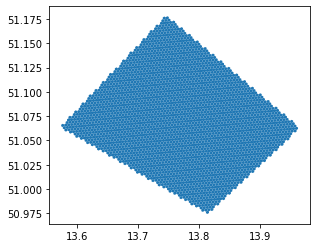

In [14]:
gdf_hexagons_small.plot()

In [15]:
gdf_hexagons_small

,h3_hex_small_id,geometry
0,891f1b4458bffff,"POLYGON ((13.77489 50.99978, 13.77501 50.99810..."
1,891f1b56b83ffff,"POLYGON ((13.71679 51.12241, 13.71690 51.12074..."
2,891f1b0b113ffff,"POLYGON ((13.82129 51.12342, 13.82140 51.12175..."
3,891f1b08627ffff,"POLYGON ((13.86001 51.10297, 13.86012 51.10129..."
4,891f1b09cb3ffff,"POLYGON ((13.88648 51.07928, 13.88659 51.07761..."
...,...,...
3201,891f1b46ad7ffff,"POLYGON ((13.80461 51.00149, 13.80472 50.99981..."
3202,891f1b198c3ffff,"POLYGON ((13.75570 51.17249, 13.75581 51.17082..."
3203,891f1b56d27ffff,"POLYGON ((13.73491 51.14864, 13.73502 51.14697..."
3204,891f1b0917bffff,"POLYGON ((13.84285 51.06167, 13.84296 51.06000..."


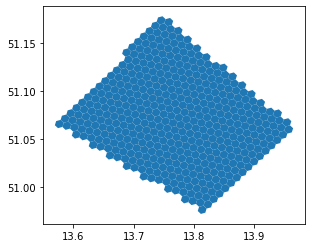

In [16]:
gdf_hexagons_big.plot()

In [17]:
gdf_hexagons_big

,h3_hex_big_id,geometry
0,881f1b4637fffff,"POLYGON ((13.76200 51.00660, 13.75981 51.00227..."
1,881f1b54a9fffff,"POLYGON ((13.70041 51.07108, 13.69822 51.06675..."
2,881f1b5591fffff,"POLYGON ((13.68728 51.04511, 13.68509 51.04078..."
3,881f1b5413fffff,"POLYGON ((13.67885 51.09501, 13.67667 51.09068..."
4,881f1b54dbfffff,"POLYGON ((13.74526 51.10644, 13.74307 51.10211..."
...,...,...
460,881f1b56ddfffff,"POLYGON ((13.70214 51.15428, 13.69995 51.14996..."
461,881f1b54b1fffff,"POLYGON ((13.73809 51.06572, 13.73590 51.06139..."
462,881f1b0b63fffff,"POLYGON ((13.76442 51.11762, 13.76222 51.11330..."
463,881f1b4663fffff,"POLYGON ((13.71837 51.02676, 13.71618 51.02243..."


### 3.3. Save hexagons as csv

In [18]:
gdf_hexagons_small.to_file(os.path.join(path_output, "hexagons-small-dresden.geojson"), driver='GeoJSON')

In [19]:
gdf_hexagons_big.to_file(os.path.join(path_output, "hexagons-big-dresden.geojson"), driver='GeoJSON')

## 4. Match corresponding hexagons to start and endpoints of trips

In [20]:
df_trips = pd.read_csv(path_trips, index_col="Unnamed: 0")
df_trips.head()

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,trip_duration,idle_time,24_sum,6_sum,2_sum,1_sum,h3_hex_small_id_start,h3_hex_small_id_end,h3_hex_big_id_start,h3_hex_big_id_end
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,...,28.0,0.0,265,36,19,8,881f1b54bbfffff,881f1b5599fffff,871f1b54bffffff,871f1b559ffffff
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,...,10.0,0.0,265,33,17,17,881f1b4609fffff,881f1b465dfffff,871f1b460ffffff,871f1b464ffffff
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,...,26.0,0.0,265,33,17,17,881f1b5591fffff,881f1b4601fffff,871f1b559ffffff,871f1b460ffffff
3,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,...,2.0,0.0,265,33,17,17,881f1b5591fffff,881f1b5591fffff,871f1b559ffffff,871f1b559ffffff
4,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,...,28.0,0.0,265,33,17,17,881f1b54b9fffff,881f1b54b9fffff,871f1b54bffffff,871f1b54bffffff


In [21]:
df_trips.columns

Index(['p_bike_racks_start', 'p_spot_start', 'p_booked_bikes_start',
       'p_place_type_start', 'datetime_start', 'b_number_start', 'p_uid_start',
       'p_bikes_start', 'p_lat_start', 'b_electric_lock_start',
       'b_bike_type_start', 'p_name_start', 'p_free_racks_start',
       'b_lock_types_start', 'p_number_start', 'p_lng_start',
       'b_boardcomputer_start', 'p_maintenance_start', 'p_bike_racks_end',
       'p_spot_end', 'p_booked_bikes_end', 'p_place_type_end', 'datetime_end',
       'p_uid_end', 'p_bikes_end', 'p_lat_end', 'p_name_end',
       'p_free_racks_end', 'p_number_end', 'p_lng_end', 'p_maintenance_end',
       'air_deg', 'air_hum', 'rain_mm', 'rain_yn', 'sun_hour', 'wind_ms',
       'month_start', 'month_end', 'day_start', 'day_end', 'day_of_week_start',
       'day_of_week_end', 'hour_start', 'hour_end', 'day_of_year_start',
       'day_of_year_end', 'season', 'weekend', 'booking_date_start',
       'trip_duration', 'idle_time', '24_sum', '6_sum', '2_sum', '1_su

In [22]:
# Get the hexagon for a data point
# Assume we have a dataframe with a column for latitude and longitude representing "point data".

# Add hex ids for small hexagons and for start and end point
df_trips["h3_hex_small_id_start"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_start"], row["p_lng_start"], H3_HEXAGON_RESOLUTION_SMALL) if (row['p_lat_start'] and row['p_lng_start']) else 0, axis=1)
df_trips["h3_hex_small_id_end"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_end"], row["p_lng_end"], H3_HEXAGON_RESOLUTION_SMALL) if (row['p_lat_end'] and row['p_lng_end']) else 0, axis=1)

# Add hex ids for big hexagons and for start and end point
df_trips["h3_hex_big_id_start"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_start"], row["p_lng_start"], H3_HEXAGON_RESOLUTION_BIG) if (row['p_lat_start'] and row['p_lng_start']) else 0, axis=1)
df_trips["h3_hex_big_id_end"] = df_trips.apply(lambda row: h3.geo_to_h3(row["p_lat_end"], row["p_lng_end"], H3_HEXAGON_RESOLUTION_BIG) if (row['p_lat_end'] and row['p_lng_end']) else 0, axis=1)
df_trips.head()

,p_bike_racks_start,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number_start,p_uid_start,p_bikes_start,p_lat_start,b_electric_lock_start,...,trip_duration,idle_time,24_sum,6_sum,2_sum,1_sum,h3_hex_small_id_start,h3_hex_small_id_end,h3_hex_big_id_start,h3_hex_big_id_end
0,0,False,0,12,2019-01-20 00:00:00,93771,12095573,1,51.071262,False,...,28.0,0.0,265,36,19,8,891f1b54bb3ffff,891f1b5598fffff,881f1b54bbfffff,881f1b5599fffff
1,0,True,0,0,2019-01-20 00:05:00,93576,10299640,5,51.038210,False,...,10.0,0.0,265,33,17,17,891f1b46097ffff,891f1b465dbffff,881f1b4609fffff,881f1b465dfffff
2,0,True,0,0,2019-01-20 00:07:00,93440,10299584,1,51.042570,True,...,26.0,0.0,265,33,17,17,891f1b55903ffff,891f1b46003ffff,881f1b5591fffff,881f1b4601fffff
3,0,False,0,12,2019-01-20 00:07:00,93322,12098234,1,51.041798,False,...,2.0,0.0,265,33,17,17,891f1b5591bffff,891f1b5591bffff,881f1b5591fffff,881f1b5591fffff
4,0,True,0,0,2019-01-20 00:07:00,93585,264575,5,51.071740,False,...,28.0,0.0,265,33,17,17,891f1b54b97ffff,891f1b54b97ffff,881f1b54b9fffff,881f1b54b9fffff


## 5. Save them into csv file chunks
- This has to be done because the file is too big to be uplaoded to Github
- But as h3 package is not working on Windows, we have to upload these files so everyone has these information
- The next notebook (03_MergeHexagonChunks) can then be run on Windows
- It loads the chunks and merges them again, creating a Trips_Hexagons.csv (which is on gitignore)

In [23]:
# Save as Trips.csv directly
df_trips.to_csv(os.path.join(path_output, "Trips.csv"))

In [ ]:
# Into how many chunks do you want to split the dataframe?
number_of_chunks = 5

for id, df_chunk in enumerate(np.array_split(df_trips, number_of_chunks)):
    df_chunk.to_csv(os.path.join(path_output, "trips-hexagons","trips-hexagons-{id}.csv").format(id=id))